In [3]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.SeqIO import FastaIO
from ete3 import NCBITaxa
import os
import math
import matplotlib
import argparse
import numpy as np
import sqlite3
from sqlite3 import Error
import datetime
import collections
import ast

In [270]:
mode = 'stats'
# db_path = 'clio_sqlite.db'
db_path = 'clio_refseq_sqlite.db'
output_dir = 'output'
taxonomy_group = "Metazoa"
marker = "12S" # 12S
markers = ["12S","16S","COI","SSU"]
min_length = 60
cluster = False
elements = [
    "record_id", "sequences",
    "kingdom_name", "kingdom",
    "phylum_name", "phylum",
    "class_name", "class",
    "order_name", "order",
    "family_name","family",
    "genus_name", "genus",
    "species_name", "species",
    "taxid", "marker",
    "database", "extra",
    "genbank_accession","bin_uri",
    "import_file"
]
ranks_verbose = {
    "kingdom":"kingdoms",
    "phylum":"phyla",
    "class":"classes",
    'order':'orders',
    "family":"families",
    "genus":"genera",
    "species":"species"
}

In [244]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
ncbi = NCBITaxa()
# ncbi.update_taxonomy_database()


In [330]:
def plot_maker(names, av_COI, av_12S, av_16S, av_SSU, to, desc, obj_name, rank_name):
    max_to = max(to)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    y_pos = np.arange(len(names))
    colors = ['red', 'green']
    bar_width = 0.2
    bar1 = ax.barh(y_pos, av_COI, bar_width,  color='red', align='edge',
                   ecolor='black')
    bar12 = ax.barh(y_pos-0.2, av_12S, bar_width, color='green', align='edge',
                    ecolor='black')
    bar13 = ax.barh(y_pos-0.4, av_16S, bar_width, color='yellow', align='edge',
                    ecolor='black')
    bar14 = ax.barh(y_pos-0.6, av_SSU, bar_width, color='blue', align='edge',
                    ecolor='black')

    bar2 = ax.barh(y_pos-0.6, to, 0.8,  color='black', align='edge',
                   ecolor='black', alpha=0.12)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.set_xticks(np.arange(0, max(to), step=5))
    ax.set_xlabel('Number of covered lower-ranks')
    ax.set_xbound(upper=max_to*1.2)
    ax.set_title('Coverage of {} markers in Clio among {} {}'.format(
        obj_name, len(to), ranks_verbose[rank_name]))
    y_length = (12 if len(names)/3 < 12 else len(names)/3)
    fig.set_size_inches(7, y_length)
#     for i, (a, t, d) in enumerate(zip(av_COI, to, desc)):
#         ax.text(a + 0.1, i, str(a), color='red')
#     for i, (a, t, d) in enumerate(zip(av_12S, to, desc)):
#         ax.text(a + 0.1, i - bar_width, str(a), color='green')
#     for i, (a, t, d) in enumerate(zip(av_16S, to, desc)):
#         ax.text(a + 0.1, i - bar_width*2, str(a), color='yellow')
#     for i, (a, t, d) in enumerate(zip(av_SSU, to, desc)):
#         ax.text(a + 0.1, i - bar_width*3, str(a), color='blue')
    
    for i, (t, d) in enumerate(zip(to, desc)):
        ax.text(t + 0.2, i - bar_width*1.5, str(t), color='black')
    
    plt.grid(axis='x',linestyle='--')
    plt.legend(["COI","12S","16S","SSU","Total lower-ranks count in NCBI"],loc=0, prop={'size': 12})
    plt.margins(0.01)
    plt.show()
    plot_name = "all" + "_" + taxonomy_group + \
        "_" + "coverage.png".format(obj_name)
    fig.savefig(output_dir + "/" + plot_name, bbox_inches='tight',)
    plt.close(fig)

In [310]:
def charter(chart_COI, chart_12S, chart_16S, chart_SSU, obj_name, rank_name):
    names = list()
    av_COI = list()
    av_12S = list()
    av_16S = list()
    av_SSU = list()
    to = list()
    desc = list()
    for rec in chart_COI:
        names.append(rec[0] + " (" + rec[3] + ")" )
        av_COI.append(rec[1])
        to.append(rec[2])
        desc.append(rec[3])
    for rec in chart_12S:
        av_12S.append(rec[1])
    for rec in chart_16S:
        av_16S.append(rec[1])
    for rec in chart_SSU:
        av_SSU.append(rec[1])
    if to.count > 0:
        plot_maker(names, av_COI, av_12S, av_16S,
                   av_SSU, to, desc, obj_name, rank_name)
    return names

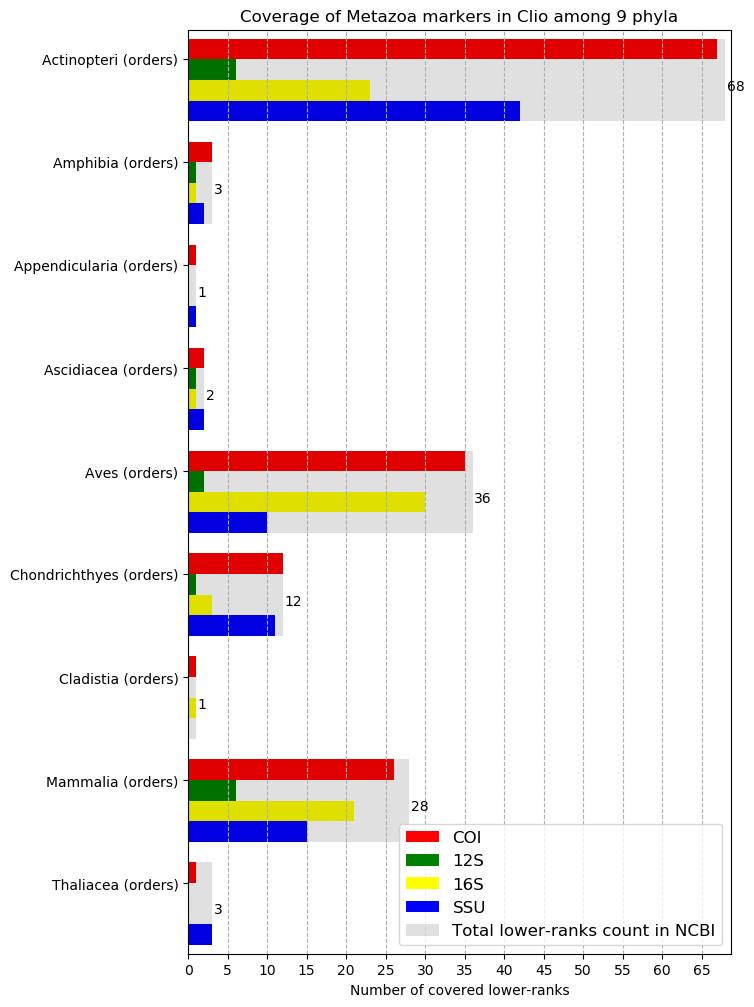

In [331]:
meta_COI = "[(u'Xenacoelomorpha', 1, 2, 'orders'), (u'Tardigrada', 1, 2, 'classes'), (u'Rotifera', 2, 3, 'classes'), (u'Rhombozoa', 0, 1, 'orders'), (u'Priapulida', 1, 1, 'classes'), (u'Porifera', 4, 4, 'classes'), (u'Platyhelminthes', 5, 6, 'classes'), (u'Placozoa', 1, 1, 'families'), (u'Orthonectida', 0, 1, 'families'), (u'Onychophora', 1, 1, 'classes'), (u'Nemertea', 3, 3, 'classes'), (u'Nematomorpha', 0, 2, 'classes'), (u'Nematoda', 2, 2, 'classes'), (u'Mollusca', 7, 8, 'classes'), (u'Loricifera', 0, 1, 'orders'), (u'Kinorhyncha', 2, 2, 'classes'), (u'Hemichordata', 2, 2, 'classes'), (u'Gnathostomulida', 1, 2, 'orders'), (u'Gastrotricha', 1, 2, 'orders'), (u'Entoprocta', 1, 3, 'families'), (u'Echinodermata', 5, 5, 'classes'), (u'Cycliophora', 0, 1, 'genera'), (u'Ctenophora', 2, 2, 'classes'), (u'Cnidaria', 5, 7, 'classes'), (u'Chordata', 9, 9, 'classes'), (u'Chaetognatha', 1, 1, 'classes'), (u'Bryozoa', 3, 3, 'classes'), (u'Brachiopoda', 2, 3, 'classes'), (u'Arthropoda', 17, 17, 'classes'), (u'Annelida', 2, 2, 'classes'), (u'Acanthocephala', 4, 4, 'classes')]"
meta_12S = "[(u'Xenacoelomorpha', 0, 2, 'orders'), (u'Tardigrada', 0, 2, 'classes'), (u'Rotifera', 0, 3, 'classes'), (u'Rhombozoa', 0, 1, 'orders'), (u'Priapulida', 0, 1, 'classes'), (u'Porifera', 2, 4, 'classes'), (u'Platyhelminthes', 0, 6, 'classes'), (u'Placozoa', 0, 1, 'families'), (u'Orthonectida', 0, 1, 'families'), (u'Onychophora', 0, 1, 'classes'), (u'Nemertea', 0, 3, 'classes'), (u'Nematomorpha', 0, 2, 'classes'), (u'Nematoda', 0, 2, 'classes'), (u'Mollusca', 1, 8, 'classes'), (u'Loricifera', 0, 1, 'orders'), (u'Kinorhyncha', 0, 2, 'classes'), (u'Hemichordata', 2, 2, 'classes'), (u'Gnathostomulida', 0, 2, 'orders'), (u'Gastrotricha', 0, 2, 'orders'), (u'Entoprocta', 0, 3, 'families'), (u'Echinodermata', 4, 5, 'classes'), (u'Cycliophora', 0, 1, 'genera'), (u'Ctenophora', 0, 2, 'classes'), (u'Cnidaria', 1, 7, 'classes'), (u'Chordata', 6, 9, 'classes'), (u'Chaetognatha', 0, 1, 'classes'), (u'Bryozoa', 0, 3, 'classes'), (u'Brachiopoda', 0, 3, 'classes'), (u'Arthropoda', 3, 17, 'classes'), (u'Annelida', 0, 2, 'classes'), (u'Acanthocephala', 3, 4, 'classes')]"
meta_16S = "[(u'Xenacoelomorpha', 0, 2, 'orders'), (u'Tardigrada', 0, 2, 'classes'), (u'Rotifera', 0, 3, 'classes'), (u'Rhombozoa', 0, 1, 'orders'), (u'Priapulida', 1, 1, 'classes'), (u'Porifera', 0, 4, 'classes'), (u'Platyhelminthes', 0, 6, 'classes'), (u'Placozoa', 0, 1, 'families'), (u'Orthonectida', 0, 1, 'families'), (u'Onychophora', 0, 1, 'classes'), (u'Nemertea', 0, 3, 'classes'), (u'Nematomorpha', 0, 2, 'classes'), (u'Nematoda', 0, 2, 'classes'), (u'Mollusca', 0, 8, 'classes'), (u'Loricifera', 0, 1, 'orders'), (u'Kinorhyncha', 0, 2, 'classes'), (u'Hemichordata', 2, 2, 'classes'), (u'Gnathostomulida', 0, 2, 'orders'), (u'Gastrotricha', 0, 2, 'orders'), (u'Entoprocta', 0, 3, 'families'), (u'Echinodermata', 4, 5, 'classes'), (u'Cycliophora', 0, 1, 'genera'), (u'Ctenophora', 0, 2, 'classes'), (u'Cnidaria', 2, 7, 'classes'), (u'Chordata', 7, 9, 'classes'), (u'Chaetognatha', 0, 1, 'classes'), (u'Bryozoa', 0, 3, 'classes'), (u'Brachiopoda', 0, 3, 'classes'), (u'Arthropoda', 2, 17, 'classes'), (u'Annelida', 0, 2, 'classes'), (u'Acanthocephala', 3, 4, 'classes')]"
meta_SSU = "[(u'Xenacoelomorpha', 2, 2, 'orders'), (u'Tardigrada', 2, 2, 'classes'), (u'Rotifera', 3, 3, 'classes'), (u'Rhombozoa', 1, 1, 'orders'), (u'Priapulida', 1, 1, 'classes'), (u'Porifera', 4, 4, 'classes'), (u'Platyhelminthes', 6, 6, 'classes'), (u'Placozoa', 1, 1, 'families'), (u'Orthonectida', 1, 1, 'families'), (u'Onychophora', 1, 1, 'classes'), (u'Nemertea', 3, 3, 'classes'), (u'Nematomorpha', 2, 2, 'classes'), (u'Nematoda', 2, 2, 'classes'), (u'Mollusca', 8, 8, 'classes'), (u'Loricifera', 1, 1, 'orders'), (u'Kinorhyncha', 0, 2, 'classes'), (u'Hemichordata', 2, 2, 'classes'), (u'Gnathostomulida', 2, 2, 'orders'), (u'Gastrotricha', 2, 2, 'orders'), (u'Entoprocta', 3, 3, 'families'), (u'Echinodermata', 5, 5, 'classes'), (u'Cycliophora', 1, 1, 'genera'), (u'Ctenophora', 2, 2, 'classes'), (u'Cnidaria', 7, 7, 'classes'), (u'Chordata', 8, 9, 'classes'), (u'Chaetognatha', 1, 1, 'classes'), (u'Bryozoa', 3, 3, 'classes'), (u'Brachiopoda', 3, 3, 'classes'), (u'Arthropoda', 16, 17, 'classes'), (u'Annelida', 2, 2, 'classes'), (u'Acanthocephala', 3, 4, 'classes')]"
chor_COI = "[(u'Thaliacea', 1, 3, 'orders'), (u'Mammalia', 26, 28, 'orders'), (u'Cladistia', 1, 1, 'orders'), (u'Chondrichthyes', 12, 12, 'orders'), (u'Aves', 35, 36, 'orders'), (u'Ascidiacea', 2, 2, 'orders'), (u'Appendicularia', 1, 1, 'orders'), (u'Amphibia', 3, 3, 'orders'), (u'Actinopteri', 67, 68, 'orders')]"
chor_12S = "[(u'Thaliacea', 0, 3, 'orders'), (u'Mammalia', 6, 28, 'orders'), (u'Cladistia', 0, 1, 'orders'), (u'Chondrichthyes', 1, 12, 'orders'), (u'Aves', 2, 36, 'orders'), (u'Ascidiacea', 1, 2, 'orders'), (u'Appendicularia', 0, 1, 'orders'), (u'Amphibia', 1, 3, 'orders'), (u'Actinopteri', 6, 68, 'orders')]"
chor_16S = "[(u'Thaliacea', 0, 3, 'orders'), (u'Mammalia', 21, 28, 'orders'), (u'Cladistia', 1, 1, 'orders'), (u'Chondrichthyes', 3, 12, 'orders'), (u'Aves', 30, 36, 'orders'), (u'Ascidiacea', 1, 2, 'orders'), (u'Appendicularia', 0, 1, 'orders'), (u'Amphibia', 1, 3, 'orders'), (u'Actinopteri', 23, 68, 'orders')]"
chor_SSU = "[(u'Thaliacea', 3, 3, 'orders'), (u'Mammalia', 15, 28, 'orders'), (u'Cladistia', 0, 1, 'orders'), (u'Chondrichthyes', 11, 12, 'orders'), (u'Aves', 10, 36, 'orders'), (u'Ascidiacea', 2, 2, 'orders'), (u'Appendicularia', 1, 1, 'orders'), (u'Amphibia', 2, 3, 'orders'), (u'Actinopteri', 42, 68, 'orders')]"
dict_COI = ast.literal_eval(chor_COI)
dict_12S = ast.literal_eval(chor_12S)
dict_16S = ast.literal_eval(chor_16S)
dict_SSU = ast.literal_eval(chor_SSU)
names = charter(dict_COI,dict_12S,dict_16S,dict_SSU,"Metazoa","phylum")
